In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import math
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

training_data = pd.read_csv('isic-2024-challenge/train-metadata.csv')
training_data.head()

/var/folders/_x/wmb0s3x168x9ps98yhxrdw940000gn/T/ipykernel_30715/1111895260.py:14: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  training_data = pd.read_csv('isic-2024-challenge/train-metadata.csv')


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


In [2]:
# helper functions
def map_to_numbers(dataset, columns):
    for column in columns:
        mapCategory = {}
        for index, item in enumerate(dataset[column].unique()):
            mapCategory[item] = index
        dataset[column].replace(to_replace = mapCategory, inplace = True)

def sanitize_data(dataset):
    non_numeric_cols = dataset.select_dtypes(exclude='number').columns.tolist()
    map_to_numbers(dataset, non_numeric_cols)

In [3]:
# drop the columns that are unimportant or have a large number/or all missing values
training_data.drop(columns = [
                    "lesion_id",
                    "iddx_full", 
                    "iddx_1",
                    "iddx_2", 
                    "iddx_3", 
                    "iddx_4", 
                    "iddx_5", 
                    "mel_mitotic_index", 
                    "mel_thick_mm",
                    "anatom_site_general",
                    "isic_id",
                    "patient_id",
                    "image_type",
                    "attribution",
                    "copyright_license"], inplace = True)

# Drop entries with NaN values
training_data.dropna(axis=0, inplace=True);
sanitize_data(training_data)

In [4]:
training_data.sample(10)

,target,age_approx,sex,clin_size_long_diam_mm,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,...,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,tbp_lv_dnn_lesion_confidence
297021,0,70.0,1,10.75,1,19.032730,15.380810,28.086610,26.153360,33.927900,...,40.313890,1.224698,1.832076,3.474216,0.539231,135,243.945900,1185.510000,91.030940,99.217150
184524,0,65.0,0,3.66,1,12.549840,7.479016,21.269710,19.848150,24.696130,...,12.854880,1.162358,3.183197,1.395960,0.214047,105,-49.477630,1361.710000,66.930480,99.999950
16806,0,50.0,0,2.86,1,30.692092,23.894389,39.928505,34.127643,50.361593,...,8.966554,1.375759,2.495184,2.450900,0.307190,90,57.586014,1326.957153,191.563904,99.999940
307789,0,60.0,0,4.39,1,9.562506,7.254906,19.849914,19.783548,22.033170,...,11.598500,0.641655,1.528670,2.743590,0.481651,170,104.739807,503.813568,50.181458,70.275593
11345,0,20.0,1,2.94,0,22.778342,20.275249,22.332741,20.809987,31.899909,...,8.338364,0.426656,1.448893,2.297796,0.245763,65,196.305054,686.766174,94.425903,64.781100
393286,0,25.0,1,3.72,0,13.160280,10.437720,30.440320,25.099440,33.163330,...,11.952720,0.567564,1.351063,1.636969,0.223140,165,46.846150,1271.613000,-25.697020,99.678420
269012,0,30.0,0,2.50,1,18.559370,14.173290,34.172160,31.747200,38.886850,...,7.663168,0.417878,3.860624,1.218897,0.520833,20,-49.658140,1224.377000,135.832400,99.999820
209221,0,35.0,0,3.06,0,22.977410,15.583390,26.840690,21.713330,35.332480,...,8.999792,0.731764,3.090529,1.937662,0.152778,65,-226.536700,1142.096000,95.641600,100.000000
178262,0,85.0,0,3.59,1,13.902140,11.405360,20.231780,21.101560,24.547800,...,12.500660,0.716771,1.011694,2.054127,0.163865,75,105.845700,1024.381000,156.970600,99.229890
169404,0,45.0,0,2.84,1,17.411480,12.182050,24.506400,24.000790,30.061990,...,8.371603,2.279777,7.470146,2.690707,0.245454,60,-398.588800,1009.586000,-11.870480,99.999980


In [5]:
training_data.describe()

,target,age_approx,sex,clin_size_long_diam_mm,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,...,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,tbp_lv_dnn_lesion_confidence
count,387655.000000,387655.000000,387655.000000,387655.000000,387655.000000,387655.000000,387655.000000,387655.000000,387655.000000,387655.000000,...,387655.000000,387655.000000,387655.000000,387655.000000,387655.000000,387655.000000,387655.000000,387655.000000,387655.000000,3.876550e+05
mean,0.000983,58.060853,0.315347,3.934350,0.702945,19.962049,14.924643,28.200243,26.838568,34.712580,...,11.893875,1.016722,2.712732,2.243678,0.307422,86.343501,-2.887141,1040.585129,55.930774,9.714536e+01
std,0.031335,13.669418,0.464655,1.746745,0.456962,3.990443,3.526464,5.247291,4.459413,5.677288,...,5.936221,0.735009,1.736452,0.622884,0.125182,52.554618,197.109642,409.721752,88.040409,9.016765e+00
min,0.000000,5.000000,0.000000,1.000000,0.000000,-2.487115,-9.080269,-0.730989,9.237066,3.054228,...,2.579237,0.000000,0.320329,0.636247,0.052034,0.000000,-624.870728,-1052.134000,-291.890442,1.261082e-16
25%,0.000000,50.000000,0.000000,2.840000,0.000000,17.328687,12.480625,24.649198,23.796289,30.954324,...,8.338364,0.563156,1.456401,1.839551,0.211864,40.000000,-146.658300,748.655520,-8.949158,9.965330e+01
50%,0.000000,60.000000,0.000000,3.370000,1.000000,19.787900,14.719890,28.094610,26.630490,34.749750,...,10.029210,0.902472,2.184189,2.155621,0.283077,90.000000,-5.406738,1173.805000,68.121948,9.999423e+01
75%,0.000000,70.000000,1.000000,4.380000,1.000000,22.282521,17.139807,31.532883,29.578885,38.329497,...,13.242335,1.335401,3.469188,2.537913,0.382812,130.000000,140.512207,1342.994509,126.746450,9.999995e+01
max,1.000000,85.000000,1.000000,28.040000,1.000000,48.189610,37.021680,54.306900,48.372700,58.765170,...,93.758999,11.491140,17.563650,25.534791,0.977055,175.000000,614.471700,1887.766846,319.407000,1.000000e+02


In [6]:
# define important features

features = training_data.dtypes.index.tolist()
print(training_data.dtypes.index.tolist())

['target', 'age_approx', 'sex', 'clin_size_long_diam_mm', 'tbp_tile_type', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext', 'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm', 'tbp_lv_eccentricity', 'tbp_lv_location', 'tbp_lv_location_simple', 'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence', 'tbp_lv_norm_border', 'tbp_lv_norm_color', 'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt', 'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z', 'tbp_lv_dnn_lesion_confidence']


/var/folders/_x/wmb0s3x168x9ps98yhxrdw940000gn/T/ipykernel_30715/2344939172.py:19: RuntimeWarning: invalid value encountered in divide
  positive_rates=(positive_hist[0]/total_hist)*100


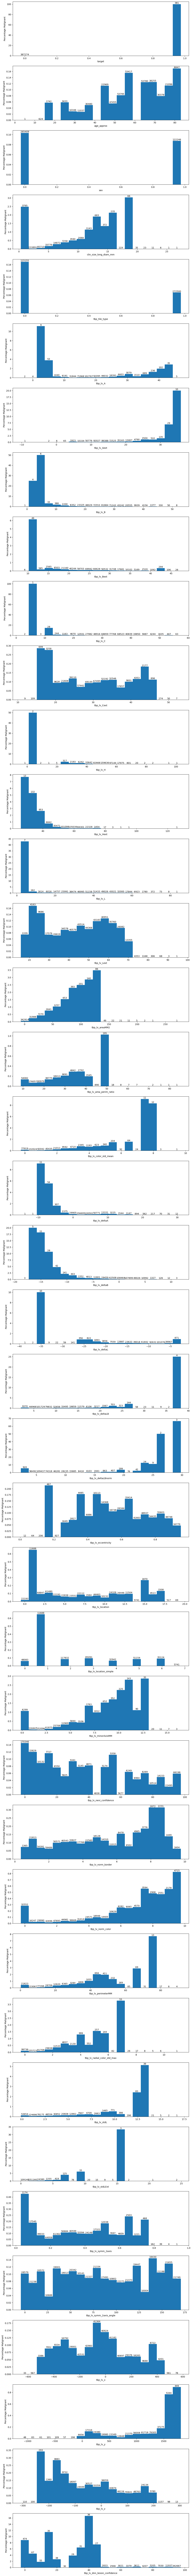

In [7]:
# plot bar charts to show the percentage of malignant lesions in each bin

df_positive=training_data[training_data['target']==1]
df_negative=training_data[training_data['target']==0]

COLUMNS = 1

figure, axes = plt.subplots(math.ceil(len(features)/COLUMNS), COLUMNS, figsize=(12,4*len(features)))

for index, feature in enumerate(features):

    min_val = training_data[feature].min()
    max_val = training_data[feature].max()
    bins=np.linspace(min_val, max_val, 21)

    positive_hist=np.histogram(df_positive[feature],bins=bins,range=(min_val,max_val))
    negative_hist=np.histogram(df_negative[feature],bins=bins,range=(min_val,max_val))
    total_hist = positive_hist[0]+negative_hist[0]
    positive_rates=(positive_hist[0]/total_hist)*100

    row, col = divmod(index, COLUMNS)

    if (COLUMNS > 1):
        bars = axes[row,col].bar(bins[:-1],positive_rates,width=bins[1]-bins[0])
        axes[row,col].set_xlabel(feature)
        axes[row,col].set_ylabel('Percentage Malignant')
        axes[row,col].bar_label(bars, total_hist)
    else:
        bars = axes[index].bar(bins[:-1],positive_rates,width=bins[1]-bins[0])
        axes[index].set_xlabel(feature)
        axes[index].set_ylabel('Percentage Malignant')
        axes[index].bar_label(bars, total_hist)

plt.tight_layout() 

In [8]:
# training

In [9]:
# split the training data into train and test sets

log_X_train, log_X_test, log_y_train, log_y_test = train_test_split(
                                        training_data.drop(columns=['target']),
                                        training_data['target'],
                                        train_size=0.8,
                                        random_state=0)

In [11]:
# before SMOTETomek
from sklearn.linear_model import LogisticRegression
blog_clf = LogisticRegression(solver = 'saga', max_iter=100, penalty='l1')

blog_clf.fit(log_X_train, log_y_train)
print(blog_clf.score(log_X_train, log_y_train))
print(blog_clf.score(log_X_test, log_y_test))

print(100 * blog_clf.score(training_data[training_data['target'] == 1].drop(columns=['target']), [1 for x in range(len(training_data[training_data['target'] == 1].drop(columns=['target'])))]))
print(100 * blog_clf.score(training_data[training_data['target'] == 0].drop(columns=['target']), [0 for x in range(len(training_data[training_data['target'] == 0].drop(columns=['target'])))]))

print(len(blog_clf.predict(log_X_train)))
print(np.count_nonzero(blog_clf.predict(log_X_train)))

/Users/jimmynguyen/miniconda3/envs/cs178/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.9990068488733539
0.9989681546736144
1.3123359580052494
99.99690141863383
310124
13


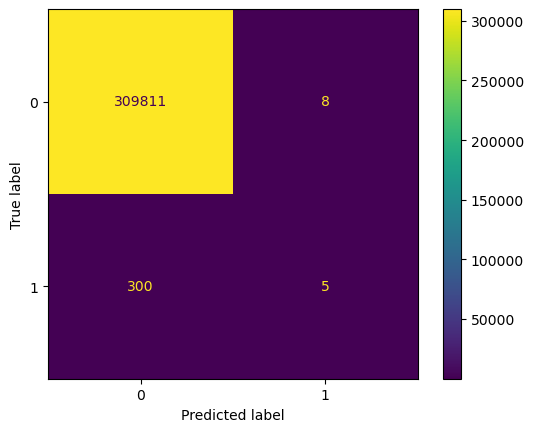

In [12]:
sklearn_cm = confusion_matrix(log_y_train, blog_clf.predict(log_X_train))
sklearn_disp = ConfusionMatrixDisplay(confusion_matrix = sklearn_cm)
sklearn_disp.plot()

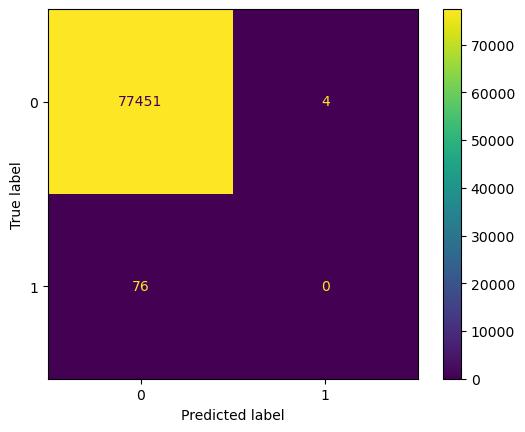

In [13]:
sklearn_cm = confusion_matrix(log_y_test, blog_clf.predict(log_X_test))
sklearn_disp = ConfusionMatrixDisplay(confusion_matrix = sklearn_cm)
sklearn_disp.plot()

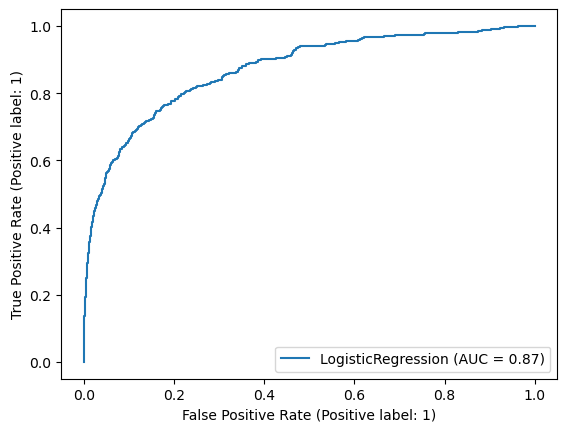

In [14]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(estimator = blog_clf, X=training_data.drop(columns=['target']), y=training_data['target'])

In [16]:
# creates a logistic regression classifier
log_clf = LogisticRegression(solver = 'saga', max_iter=100, penalty='l1')

In [17]:
# Define SMOTE-Tomek Links
resample = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
# Define pipeline
pipeline = Pipeline(steps=[('r', resample), ('m', log_clf)])
# Fit Model
pipeline.fit(log_X_train, log_y_train)

/Users/jimmynguyen/miniconda3/envs/cs178/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Pipeline(steps=[('r',
                 SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))),
                ('m', LogisticRegression(penalty='l1', solver='saga'))])

In [18]:
print(log_clf.score(log_X_train, log_y_train))
print(log_clf.score(log_X_test, log_y_test))

print(100 * log_clf.score(training_data[training_data['target'] == 1].drop(columns=['target']), [1 for x in range(len(training_data[training_data['target'] == 1].drop(columns=['target'])))]))
print(100 * log_clf.score(training_data[training_data['target'] == 0].drop(columns=['target']), [0 for x in range(len(training_data[training_data['target'] == 0].drop(columns=['target'])))]))

print(len(log_clf.predict(log_X_train)))
print(np.count_nonzero(log_clf.predict(log_X_train)))

0.8774264487753286
0.8779971882214856
74.80314960629921
87.76680076638246
310124
38176


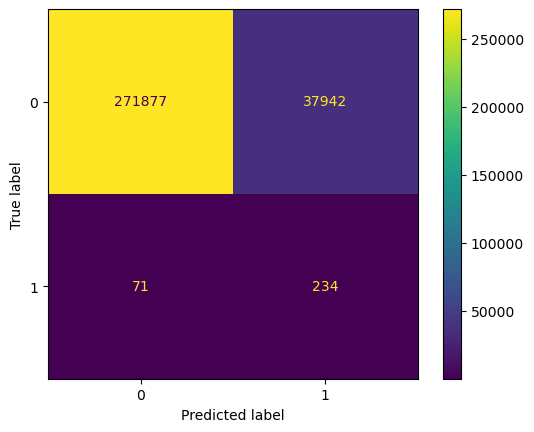

In [19]:
# Display Confusion Matrix
sklearn_cm = confusion_matrix(log_y_train, log_clf.predict(log_X_train))
sklearn_disp = ConfusionMatrixDisplay(confusion_matrix = sklearn_cm)
sklearn_disp.plot()

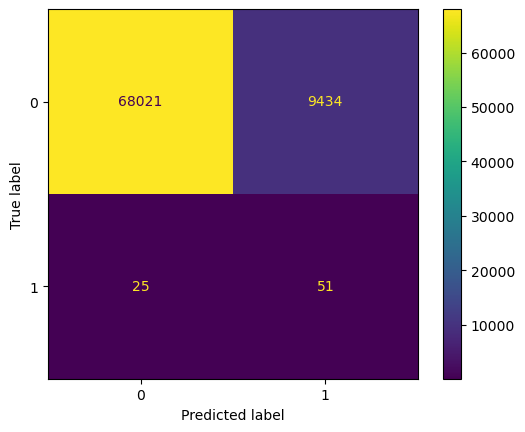

In [20]:
sklearn_cm = confusion_matrix(log_y_test, log_clf.predict(log_X_test))
sklearn_disp = ConfusionMatrixDisplay(confusion_matrix = sklearn_cm)
sklearn_disp.plot()

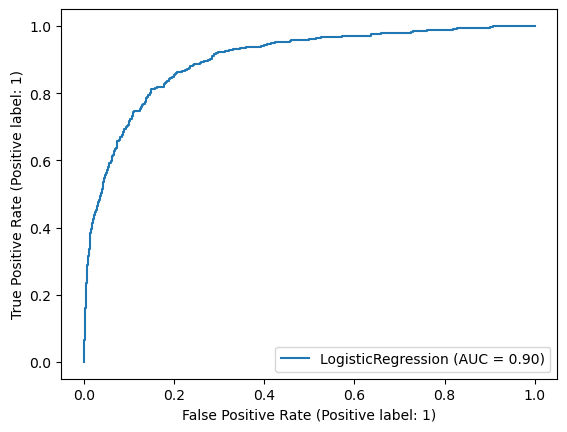

In [21]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(estimator = log_clf, X=training_data.drop(columns=['target']), y=training_data['target'])

In [22]:
from sklearn.inspection import permutation_importance

importances = permutation_importance(log_clf, log_X_train, log_y_train)
importances['importances_mean']   

array([-1.46135094e-03, -1.80314971e-03,  2.37253486e-02, -8.17479460e-03,
       -5.74608866e-03, -1.09659362e-02,  1.97024416e-02,  2.31288130e-02,
        2.38485251e-03,  5.98941069e-02, -1.71576531e-02,  9.77860469e-02,
        6.56318118e-03,  1.78186790e-03, -3.38832209e-03,  5.16006501e-02,
       -7.24226438e-04, -1.82185190e-03, -1.19371606e-03,  2.97816357e-03,
        2.96732920e-02,  9.98310353e-04, -2.33455005e-04, -1.84700313e-03,
        8.89966594e-05, -5.08828727e-03,  1.23821439e-03,  6.92497195e-03,
       -3.79074177e-03, -6.84887335e-04, -3.55083773e-03,  7.54794856e-03,
       -2.05724162e-03, -1.22531633e-05, -1.44458346e-04,  2.78856199e-03,
       -1.74704312e-03, -6.64895332e-04, -1.40201984e-03])

In [23]:
df = pd.DataFrame({'feature': training_data.drop(columns=['target']).columns, 'value': importances['importances_mean']})
df_sorted = df.reindex(df['value'].abs().sort_values(ascending=False).index)
print(df_sorted)

                         feature     value
11                   tbp_lv_Hext  0.097786
9                    tbp_lv_Cext  0.059894
15       tbp_lv_area_perim_ratio  0.051601
20                tbp_lv_deltaLB  0.029673
2         clin_size_long_diam_mm  0.023725
7                    tbp_lv_Bext  0.023129
6                       tbp_lv_B  0.019702
10                      tbp_lv_H -0.017158
5                    tbp_lv_Aext -0.010966
3                  tbp_tile_type -0.008175
31                   tbp_lv_stdL  0.007548
27            tbp_lv_norm_border  0.006925
12                      tbp_lv_L  0.006563
4                       tbp_lv_A -0.005746
25            tbp_lv_minorAxisMM -0.005088
28             tbp_lv_norm_color -0.003791
30   tbp_lv_radial_color_std_max -0.003551
14                tbp_lv_areaMM2 -0.003388
19                 tbp_lv_deltaL  0.002978
35                      tbp_lv_x  0.002789
8                       tbp_lv_C  0.002385
32                tbp_lv_stdLExt -0.002057
23         

In [26]:
# from PIL import Image
# import os

# image_dir = 'isic-2024-challenge/train-image/image/'

# X = []
# y = []
# training_data = pd.read_csv('isic-2024-challenge/train-metadata.csv')
# for _, row in training_data.iterrows():
#     id = str(row['isic_id'])
#     label = row['target']
    
#     img_path = os.path.join(image_dir, f"{id}.jpg")
    
#     img = Image.open(img_path).convert('L').resize((128, 128))  # 'L' = grayscale
    
#     # Flatten the image (128x128 = 16,384 features)
#     img_array = np.array(img).flatten()
    
#     X.append(img_array)
#     y.append(label)

# X = np.array(X)
# y = np.array(y)

# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

In [25]:
# # Define SMOTE-Tomek Links
# im_log_clf = LogisticRegression(solver = 'saga', max_iter=100, penalty='l1')
# resample = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
# # Define pipeline
# pipeline = Pipeline(steps=[('r', resample), ('m', im_log_clf)])
# # Fit Model
# pipeline.fit(X_train, y_train)

In [24]:
# # Display Confusion Matrix
# sklearn_cm = confusion_matrix(y_train, im_log_clf.predict(X_train))
# sklearn_disp = ConfusionMatrixDisplay(confusion_matrix = sklearn_cm)
# sklearn_disp.plot()